In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers # requires transformers==4.35.2
device = torch.device('cuda:0')

/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
print(transformers.__version__)

4.35.1


In [3]:
draft_model_name = "deepseek-ai/deepseek-coder-1.3b-base"
draft_model = AutoModelForCausalLM.from_pretrained(draft_model_name, trust_remote_code=True, device_map="cuda:0", torch_dtype=torch.float16, use_flash_attention_2=True)
print(draft_model.device)

/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


cuda:0


/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
model_name = "nuprl/EditCoder-6.7b-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="cuda:1", torch_dtype=torch.float16, use_flash_attention_2=True) # , use_flash_attention=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
speedup_txt = """
from typing import List

class Node:
    '''Simple node (No duplicate edges between nodes)'''
    def __init__(self, id: int, out_edges: List[int]):
        uniques = {}
        for edge in out_edges:
            if edge in uniques.keys():
                raise RuntimeError
            else:
                uniques[edge] = True
        self.id = id
        self.in_edges = out_edges

class Graph:
    '''Simple directed graph (No duplicate edges between nodes, no duplicate nodes)'''
    def __init__(self, nodes: List[Node]):
        uniques = {}
        for node in nodes:
            if node in uniques:
                raise RuntimeError
            else:
                uniques[node] = True
        self.nodes = nodes
        
    def find_node(self, id: int):
        for node in self.nodes:
            if node.id == id:
                return node
    
    def topological_sort(self) -> List[Node]:
        return self.nodes
"""
print(len(tokenizer.encode(speedup_txt)))

257


In [6]:
model.device

device(type='cuda', index=1)

In [7]:
NEWLINE_THRESHOLD = 10

In [8]:
import copy
import inspect
import warnings
from dataclasses import dataclass
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union

import torch
import torch.distributed as dist
from torch import nn

from transformers.integrations.deepspeed import is_deepspeed_zero3_enabled
from transformers.modeling_outputs import CausalLMOutputWithPast, Seq2SeqLMOutput
from transformers.models.auto import (
    MODEL_FOR_CAUSAL_IMAGE_MODELING_MAPPING,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    MODEL_FOR_SEQ_TO_SEQ_CAUSAL_LM_MAPPING,
    MODEL_FOR_SPEECH_SEQ_2_SEQ_MAPPING,
    MODEL_FOR_VISION_2_SEQ_MAPPING,
)
from transformers.utils import ExplicitEnum, ModelOutput, is_accelerate_available, logging
from transformers.generation.beam_constraints import DisjunctiveConstraint, PhrasalConstraint
from transformers.generation.beam_search import BeamScorer, BeamSearchScorer, ConstrainedBeamSearchScorer
from transformers.generation.configuration_utils import GenerationConfig
from transformers.generation.logits_process import (
    EncoderNoRepeatNGramLogitsProcessor,
    EncoderRepetitionPenaltyLogitsProcessor,
    EpsilonLogitsWarper,
    EtaLogitsWarper,
    ExponentialDecayLengthPenalty,
    ForcedBOSTokenLogitsProcessor,
    ForcedEOSTokenLogitsProcessor,
    ForceTokensLogitsProcessor,
    HammingDiversityLogitsProcessor,
    InfNanRemoveLogitsProcessor,
    LogitNormalization,
    LogitsProcessorList,
    MinLengthLogitsProcessor,
    MinNewTokensLengthLogitsProcessor,
    NoBadWordsLogitsProcessor,
    NoRepeatNGramLogitsProcessor,
    PrefixConstrainedLogitsProcessor,
    RepetitionPenaltyLogitsProcessor,
    SequenceBiasLogitsProcessor,
    SuppressTokensAtBeginLogitsProcessor,
    SuppressTokensLogitsProcessor,
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
    TypicalLogitsWarper,
    UnbatchedClassifierFreeGuidanceLogitsProcessor,
)
from transformers.generation.stopping_criteria import (
    MaxLengthCriteria,
    MaxTimeCriteria,
    StoppingCriteria,
    StoppingCriteriaList,
    validate_stopping_criteria,
)

from transformers.generation.utils import _crop_past_key_values
import difflib

@dataclass
class GreedySearchDecoderOnlyOutput(ModelOutput):
    """
    Base class for outputs of decoder-only generation models using greedy search.


    Args:
        sequences (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            The generated sequences. The second dimension (sequence_length) is either equal to `max_length` or shorter
            if all batches finished early due to the `eos_token_id`.
        scores (`tuple(torch.FloatTensor)` *optional*, returned when `output_scores=True` is passed or when `config.output_scores=True`):
            Processed prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
            at each generation step. Tuple of `torch.FloatTensor` with up to `max_new_tokens` elements (one element for
            each generated token), with each tensor of shape `(batch_size, config.vocab_size)`.
        attentions (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_attentions=True` is passed or `config.output_attentions=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, num_heads, generated_length, sequence_length)`.
        hidden_states (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, generated_length, hidden_size)`.
    """

    sequences: torch.LongTensor = None
    scores: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
    hidden_states: Optional[Tuple[Tuple[torch.FloatTensor]]] = None




In [94]:
@torch.no_grad()
def find_candidate_pred_tokens(input_ids, max_ngram_size=3, num_pred_tokens=10):
    input_length = input_ids.size(1)

    # Ensure max_ngram_size and num_pred_tokens are valid
    if max_ngram_size <= 0 or num_pred_tokens <= 0 or max_ngram_size > input_length:
        raise ValueError("Invalid max_ngram_size or num_pred_tokens")

    for ngram_size in range(max_ngram_size, 0, -1):
        # Extract the last n tokens as our search ngram
        ngram = input_ids[0, -ngram_size:].tolist()

        # Create sliding windows of size ngram_size
        windows = input_ids.unfold(dimension=1, size=ngram_size, step=1)

        # Convert ngram to a tensor for comparison
        ngram_tensor = torch.tensor(ngram, device=input_ids.device).unsqueeze(0)

        # Find where the windows match the ngram
        matches = (windows == ngram_tensor).all(dim=2)

        # Get the indices of matches
        match_indices = matches.nonzero(as_tuple=True)[1]

        # Iterate through match indices to find a valid continuation
        for idx in match_indices:
            start_idx = idx + ngram_size
            end_idx = start_idx + num_pred_tokens
            # Ensure we don't go beyond the length of input_ids and avoid self-match
            # if end_idx <= input_length and start_idx < input_length - ngram_size:
            #     return input_ids[0, start_idx:end_idx]
            if start_idx < input_length - ngram_size:
                return input_ids[0, start_idx:min(end_idx, input_length)]

    # If no match is found, return an empty tensor
    return torch.tensor([], dtype=torch.long, device=input_ids.device)

In [164]:
@torch.no_grad()
def find_candidate_pred_tokens_diff(input_ids, code_ids, orig_input_len=0, ngram_size=3, num_pred_tokens=10):
    # start_time = time.perf_counter()
    input_length = input_ids.size(1)
    code_length = len(code_ids)

    # Ensure max_ngram_size and num_pred_tokens are valid
    if ngram_size <= 0 or ngram_size > input_length:
        raise ValueError("Invalid max_ngram_size or num_pred_tokens")

    sm = difflib.SequenceMatcher(None, code_ids, input_ids[0, orig_input_len:].tolist())
    
    deleted = added = changed = same = last_deleted = 0
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'replace':
            changed += i2 - i1
        elif tag == 'delete':
            deleted += i2 - i1
            last_deleted = i2 - i1
        elif tag == 'insert':
            added += j2 - j1
        elif tag == 'equal':
            same += i2 - i1
    
    approx_tokens_original = changed + deleted + same - last_deleted

    lookback_start = max(input_length - ngram_size, orig_input_len)
    search_ngram = input_ids[0, lookback_start:].tolist()

    for ngram_start in range(max(0, approx_tokens_original - ngram_size), len(code_ids)):
        # if there is a match, return the entire rest of the tokens.
        if ngram_start + len(search_ngram) >= len(code_ids):
            break
        if search_ngram == code_ids[ngram_start:ngram_start + len(search_ngram)]:
            return torch.tensor(code_ids[ngram_start + len(search_ngram):max(ngram_start + len(search_ngram) + num_pred_tokens, len(code_ids))], dtype=torch.long, device=input_ids.device)

    # If no match is found, return what the answer would be otherwise
    # print("Diff searching took: ", time.perf_counter() - start_time)
    return find_candidate_pred_tokens(input_ids, ngram_size, num_pred_tokens)
    # return torch.tensor([], dtype=torch.long, device=input_ids.device)


In [165]:
COLORS = ["\x1b[31m", "\x1b[32m", "\x1b[34m", "\x1b[35m"]  # Red, Green, Blue, Magenta
UNDERLINE = "\x1b[4m"
RESET = "\x1b[0m"

In [166]:
@torch.no_grad()
def greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        draft_matching_window_size = 3,
        draft_num_candidate_tokens = 10,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0

        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens(input_ids, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == 185): # Is a newline
                        flag = False
                if flag:
                    break

            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [167]:
@torch.no_grad()
def assistant_greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        code_ids,
        start_point: int,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        prompt_matching_window_size = 3,
        prompt_num_candidate_tokens = 10,
        draft_num_candidate_rounds = 4,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        # scores = () if (return_dict_in_generate and output_scores) else None
        scores = None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0
        matching_original = True

        input_token_len = input_ids.shape[-1]
    
        for i in range(draft_num_candidate_rounds):
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens_diff(input_ids, code_ids, start_point, prompt_matching_window_size, prompt_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # print(model_inputs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == 185): # Is a newline
                        flag = False
                if flag:
                    break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        return input_ids[0, input_token_len:], model_kwargs

In [168]:
@torch.no_grad()
def greedy_search_assistant_pld(
        self,
        input_ids: torch.LongTensor,
        code_ids,
        assistant_model: torch.nn.Module,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        assistant_prompt_matching_window_size = 3,
        assistant_prompt_candidate_tokens = 10,
        assistant_draft_candidate_rounds = 4,
        max_draft_num_candidate_tokens = 300,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0

        assistant_model_kwargs = {}

        generation_start_point = input_ids.shape[-1]

        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            
            input_ids = input_ids.to(assistant_model.device)
            candidate_pred_tokens, assistant_model_kwargs = assistant_model.assistant_greedy_search_pld(input_ids,
                    code_ids,
                    generation_start_point,
                  stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=cur_len + max_draft_num_candidate_tokens)]),
                  draft_num_candidate_rounds=assistant_draft_candidate_rounds,
                  prompt_matching_window_size=assistant_prompt_matching_window_size,
                  prompt_num_candidate_tokens = assistant_prompt_candidate_tokens,
                  use_cache=True, 
                  pad_token_id=tokenizer.pad_token_id,
                  eos_token_id=tokenizer.eos_token_id,
                    print_output=False
            )
            input_ids = input_ids.to(self.device)
            candidate_pred_tokens = candidate_pred_tokens.to(self.device)

            # print(candidate_pred_tokens)
            
            # candidate_pred_tokens = find_candidate_pred_tokens(input_ids, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == 185): # Is a newline
                        flag = False
                if flag:
                    break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)
            # New cache size - 1 because the target model generates another token not yet considered by the drafter/assistant
            if "past_key_values" in assistant_model_kwargs:
                assistant_model_kwargs["past_key_values"] = _crop_past_key_values(assistant_model, assistant_model_kwargs["past_key_values"], new_cache_size - 1) 

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [169]:
print(tokenizer.encode("..."))
print(tokenizer.encode("""
"""))
print(tokenizer.encode("##"))

[32013, 1202]
[32013, 185]
[32013, 1672]


In [170]:
code_text = """import numpy as np
import matplotlib.pyplot as plt

# Calculate the average
average_throughput = np.mean(tokens_per_sec_arr)
print(f"Average Throughput: {average_throughput} tokens/sec")

# Plotting the histogram
plt.hist(tokens_per_sec_arr, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Throughput Values')
plt.xlabel('Tokens per Second')
plt.ylabel('Frequency')
plt.axvline(average_throughput, color='red', linestyle='dashed', linewidth=1)
plt.text(average_throughput*0.9, max(plt.ylim())*0.9, f'Average: {average_throughput:.2f}', color = 'red')
plt.show()
"""

question = "Can you please change x axis to start from 0"
prompt = "[INST] Code:```python\n{code_text}``` \n\n Question: {question} \n\n Modified code:[/INST]".format(code_text=code_text, question=question)

inputs = tokenizer(prompt, return_tensors="pt")
# Move all tensor values in the inputs to GPU
for key in inputs:
    inputs[key] = inputs[key].to(device)

In [171]:
model.greedy_search_assistant_pld = greedy_search_assistant_pld.__get__(model, type(model))
model.greedy_search_pld = greedy_search_pld.__get__(model, type(model))
# draft_model.greedy_search_pld = greedy_search_pld.__get__(draft_model, type(draft_model))
draft_model.assistant_greedy_search_pld = assistant_greedy_search_pld.__get__(draft_model, type(draft_model))

In [172]:
print("Model device: ", model.device)
print("Draft model device: ", draft_model.device)

Model device:  cuda:1
Draft model device:  cuda:0


In [173]:
from datasets import load_dataset

ds = load_dataset("nuprl/CanItEdit", split="test")

In [174]:
import time
from transformers import StoppingCriteriaList, MaxLengthCriteria

# Define the variable for max_new_tokens


In [181]:
from tqdm import tqdm
token_count = []
for row in tqdm(ds):
    token_count.append(len(tokenizer.encode(row['before'])))
print(token_count)
print(len(token_count))

100%|███████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1193.69it/s]

[84, 76, 774, 285, 220, 476, 264, 420, 745, 430, 580, 356, 1022, 780, 526, 740, 64, 43, 840, 160, 663, 78, 867, 72, 255, 508, 381, 242, 116, 24, 508, 359, 1178, 307, 264, 224, 121, 119, 177, 176, 367, 313, 1943, 523, 1487, 63, 801, 84, 206, 29, 86, 168, 278, 185, 495, 313, 444, 318, 408, 228, 147, 53, 111, 250, 275, 269, 645, 334, 314, 253, 1179, 348, 267, 324, 75, 116, 61, 81, 337, 408, 649, 373, 197, 187, 1157, 612, 343, 253, 686, 1292, 530, 208, 708, 659, 320, 215, 978, 600, 1201, 188, 555, 449, 185, 210, 497]
105


In [176]:
def show_token_split_graphs(time_dict, token_list):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Generate synthetic data
    np.random.seed(42)
    z = np.array(token_list)
    x = np.array(time_dict["with_assistant"])
    y = np.array(time_dict["without_assistant"])
    
    # Calculate x/y
    ratio = x / y
    
    # Create masks for the different z ranges
    mask_1 = z < 250
    mask_2 = (z >= 250) & (z < 500)
    mask_3 = (z >= 500) & (z < 1000)
    mask_4 = z >= 1000
    
    # Create histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Histogram for z < 250
    axs[0, 0].hist(ratio[mask_1], bins=30, color='blue', edgecolor='black')
    axs[0, 0].set_title('token count < 250')
    axs[0, 0].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[0, 0].set_ylabel('Frequency')
    
    # Histogram for 250 < z < 500
    axs[0, 1].hist(ratio[mask_2], bins=30, color='green', edgecolor='black')
    axs[0, 1].set_title('250 < token count < 500')
    axs[0, 1].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[0, 1].set_ylabel('Frequency')
    
    # Histogram for 500 < z < 1000
    axs[1, 0].hist(ratio[mask_3], bins=30, color='red', edgecolor='black')
    axs[1, 0].set_title('500 < token count < 1000')
    axs[1, 0].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[1, 0].set_ylabel('Frequency')
    
    # Histogram for z >= 1000
    axs[1, 1].hist(ratio[mask_4], bins=30, color='purple', edgecolor='black')
    axs[1, 1].set_title('token count >= 1000')
    axs[1, 1].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[1, 1].set_ylabel('Frequency')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

    print("Average speedup ratio: ", np.mean(ratio))
    print("Average time with assistant: ", np.mean(x))
    print("Average time without assistant: ", np.mean(y))


In [184]:
lookup_tokens = [10, 20, 40, 80, 160, 320]
time_taken = {x: {"with_assistant": [], "without_assistant": []} for x in lookup_tokens}
outputs = {x: {"with_assistant": [], "without_assistant": []} for x in lookup_tokens}

100%|█████████████████████████████████████████████████████████| 105/105 [13:06<00:00,  7.49s/it]


Analysis for lookup tokens:  10


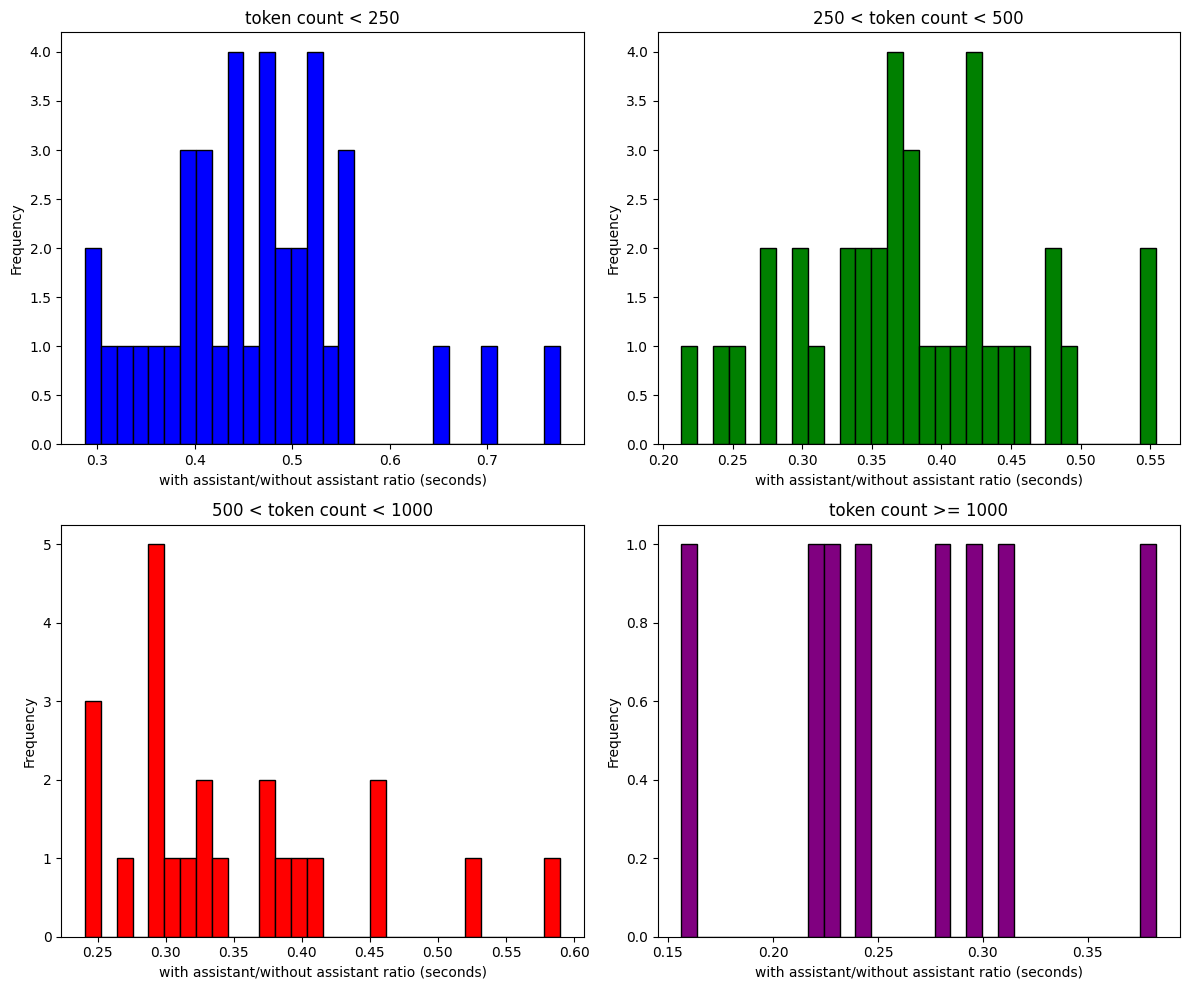

Average speedup ratio:  0.39487548738173117
Average time with assistant:  2.0427591335915385
Average time without assistant:  5.438240302407316


100%|█████████████████████████████████████████████████████████| 105/105 [11:20<00:00,  6.48s/it]


Analysis for lookup tokens:  20


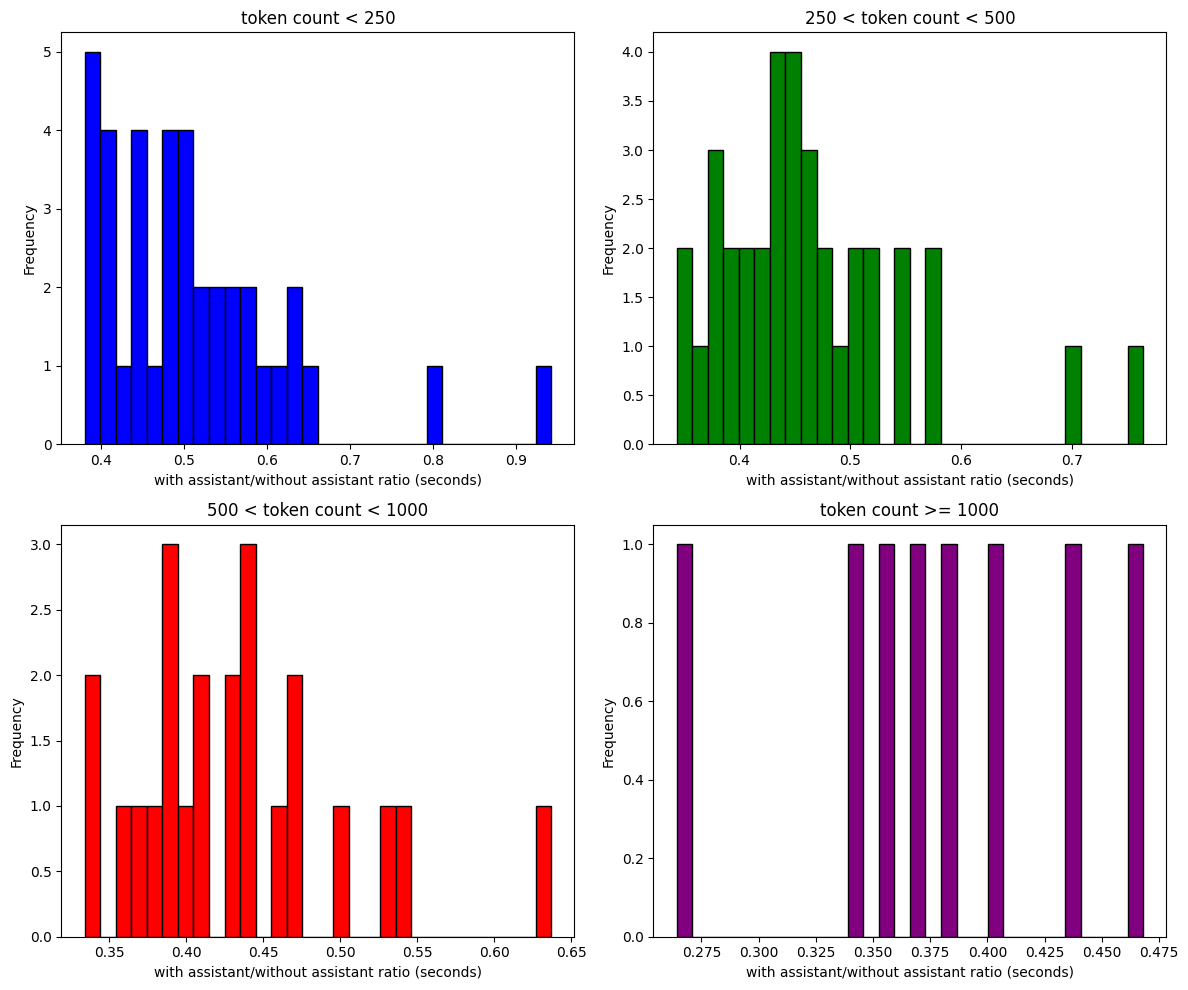

Average speedup ratio:  0.4681871659845357
Average time with assistant:  2.0146500477656013
Average time without assistant:  4.464218036245023


100%|█████████████████████████████████████████████████████████| 105/105 [10:17<00:00,  5.88s/it]


Analysis for lookup tokens:  40


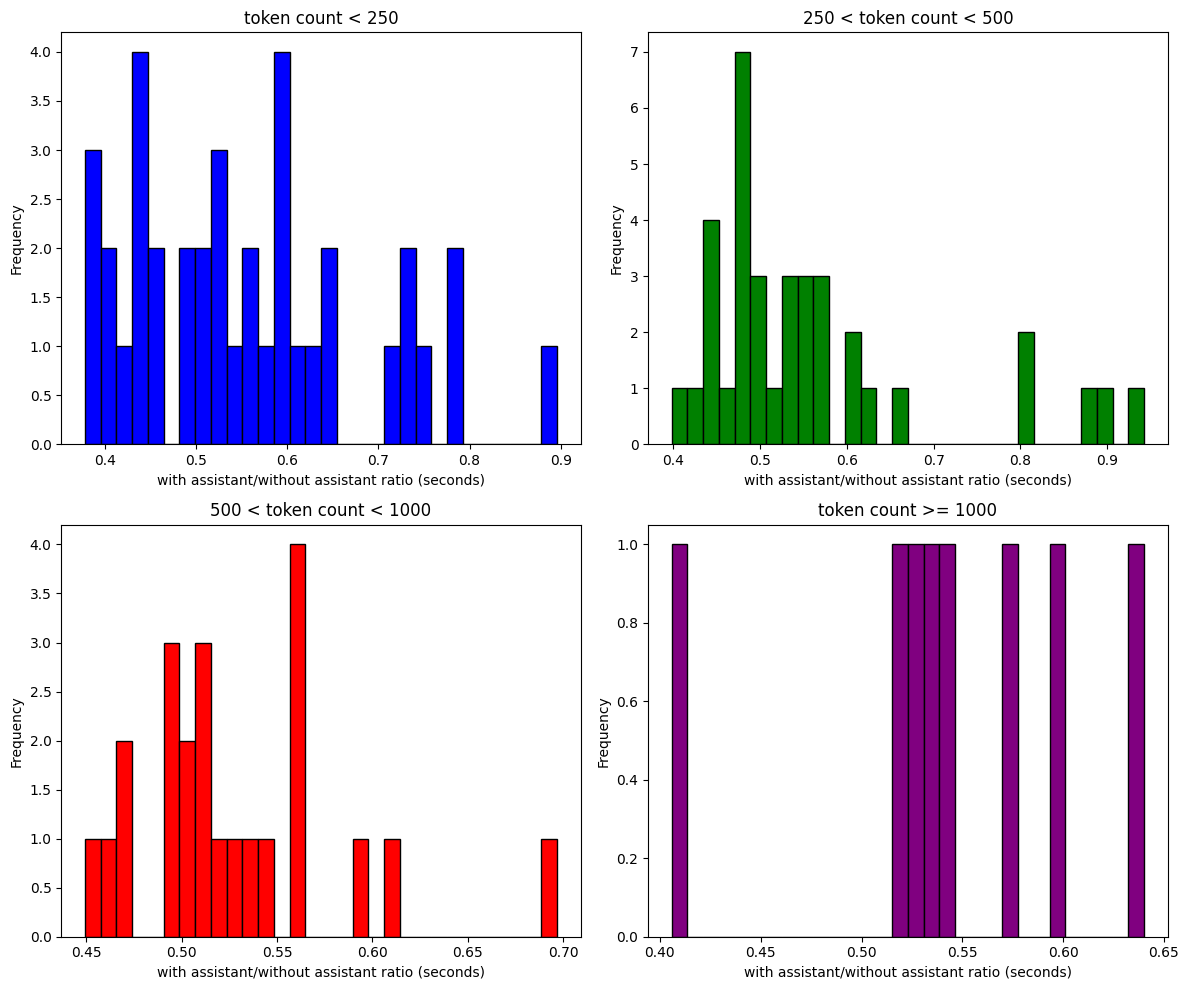

Average speedup ratio:  0.5508870190515724
Average time with assistant:  2.0220906299139774
Average time without assistant:  3.8552982187342075


100%|█████████████████████████████████████████████████████████| 105/105 [10:40<00:00,  6.10s/it]


Analysis for lookup tokens:  80


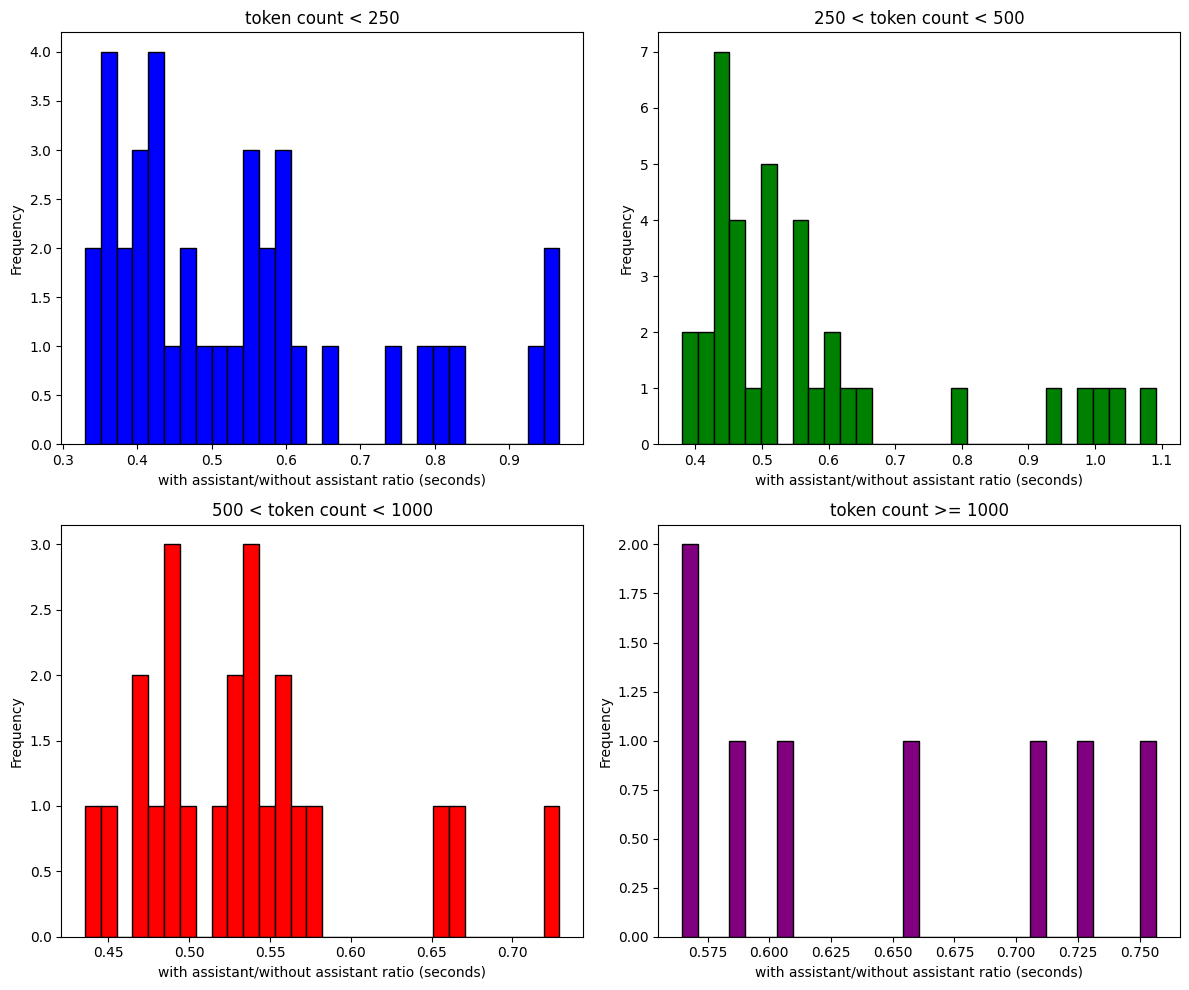

Average speedup ratio:  0.5599050965856536
Average time with assistant:  2.050316284969449
Average time without assistant:  4.046675481256985


100%|█████████████████████████████████████████████████████████| 105/105 [13:32<00:00,  7.73s/it]


Analysis for lookup tokens:  160


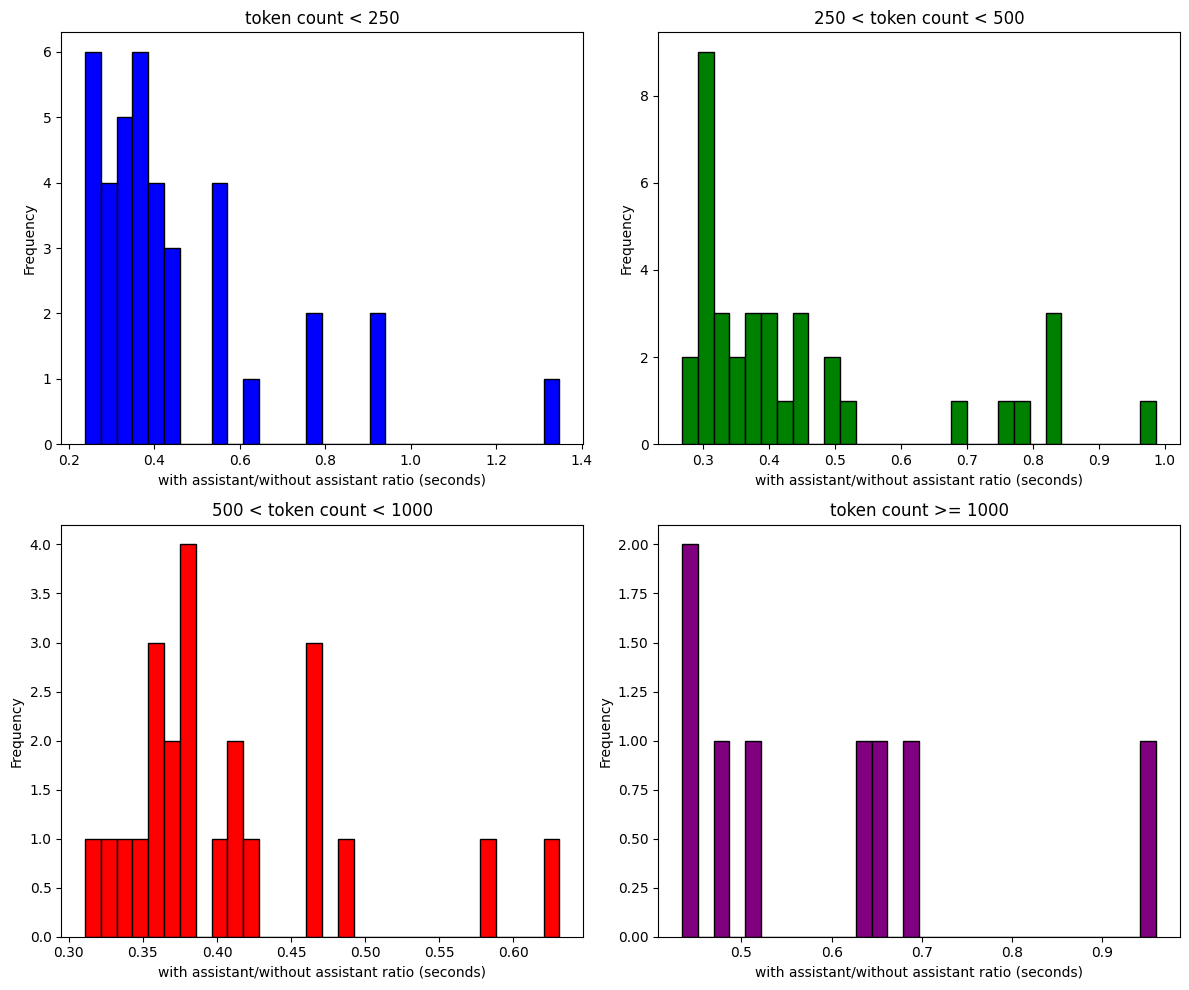

Average speedup ratio:  0.45175365801767703
Average time with assistant:  2.119976982988772
Average time without assistant:  5.610245463358504


100%|█████████████████████████████████████████████████████████| 105/105 [15:49<00:00,  9.04s/it]


Analysis for lookup tokens:  320


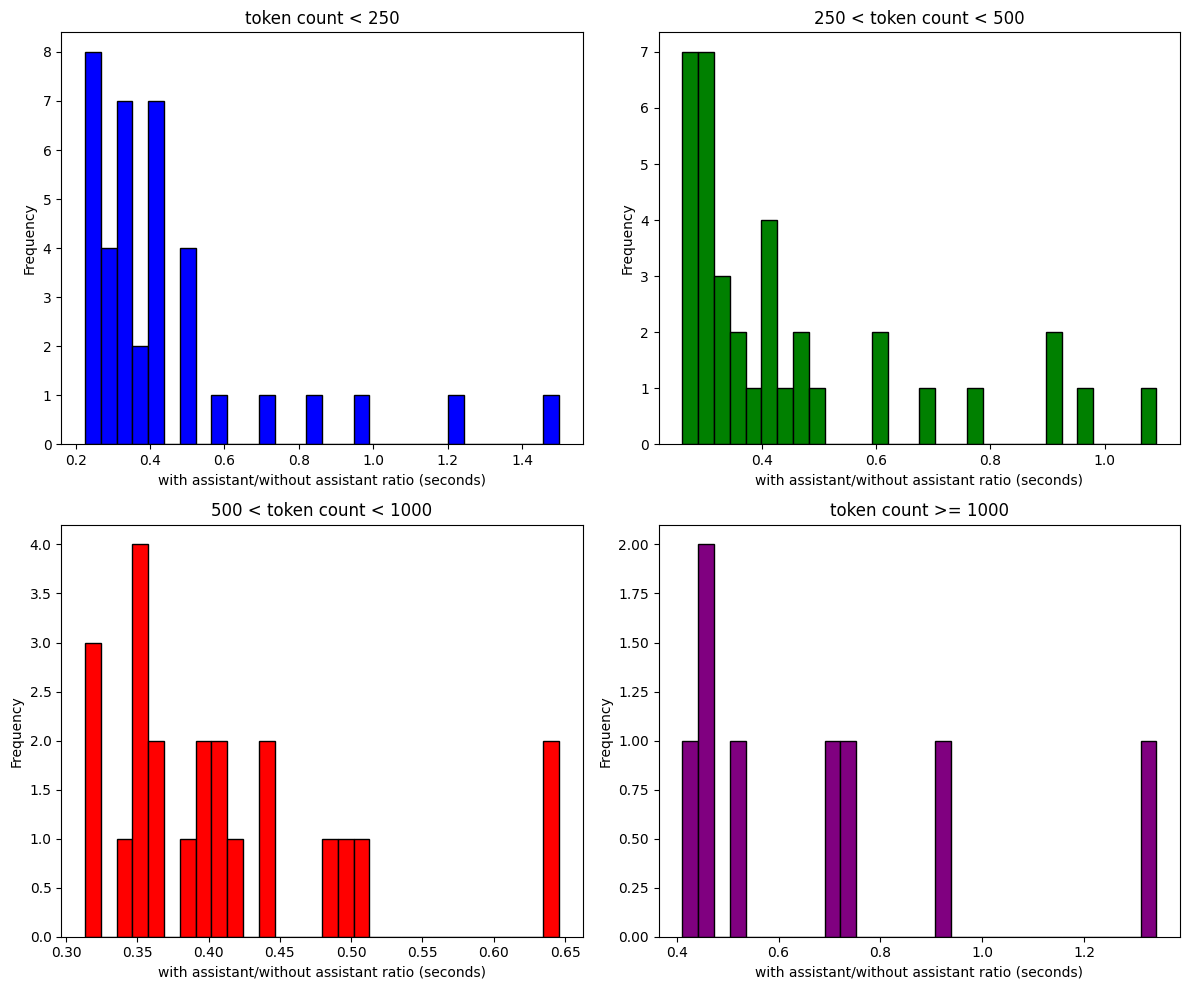

Average speedup ratio:  0.45906336938211223
Average time with assistant:  2.437231470928306
Average time without assistant:  6.597846301840175


In [185]:
for lt in lookup_tokens:
    for row in tqdm(ds):
        input_text = "## Code Before:\n{code_text}\n## Instruction: {question}\n## Code After:\n".format(code_text=row['before'], question=row['instruction_descriptive'])
        inputs = tokenizer(input_text, return_tensors="pt")
        for key in inputs:
            inputs[key] = inputs[key].to(model.device)
        code_ids = tokenizer(row['before'], return_tensors="pt").input_ids[0].tolist()
            
        max_new_tokens = inputs['input_ids'].shape[-1] + 300
    
        start_time = time.perf_counter()
        test_out = model.greedy_search_assistant_pld(inputs.input_ids,
                        code_ids,
                        draft_model,
                      attention_mask = inputs.attention_mask,
                      stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                    assistant_prompt_matching_window_size = 5,
                    assistant_prompt_candidate_tokens = lt,
                    assistant_draft_candidate_rounds = 4,
                    max_draft_num_candidate_tokens = 1000,
                      use_cache=True, 
                      pad_token_id=tokenizer.pad_token_id,
                      eos_token_id=tokenizer.eos_token_id,
                    print_output=False,
                    seed=10
                )
        end_time = time.perf_counter()
    
        time_taken[lt]["with_assistant"].append(end_time - start_time)
        outputs[lt]["with_assistant"].append(tokenizer.batch_decode(test_out))
    
        start_time = time.perf_counter()
        test_out = model.greedy_search_pld(inputs.input_ids,
                        draft_model,
                      attention_mask = inputs.attention_mask,
                      stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                    draft_matching_window_size = 5,
                    draft_num_candidate_tokens = lt,
                      use_cache=True, 
                      pad_token_id=tokenizer.pad_token_id,
                      eos_token_id=tokenizer.eos_token_id,
                     print_output=False,
                    seed=10
                )
        end_time = time.perf_counter()
        
        time_taken[lt]["without_assistant"].append(end_time - start_time)
        outputs[lt]["without_assistant"].append(tokenizer.batch_decode(test_out))
    
        # print(time_taken[lt]["with_assistant"][-1], time_taken[lt]["without_assistant"][-1])
    print("Analysis for lookup tokens: ", lt)
    show_token_split_graphs(time_taken[lt], token_count)

Without assistant :  0.31694854237139225  lookup val:  160  With assistant:  0.3650539219379425  lookup val:  80 <- greater


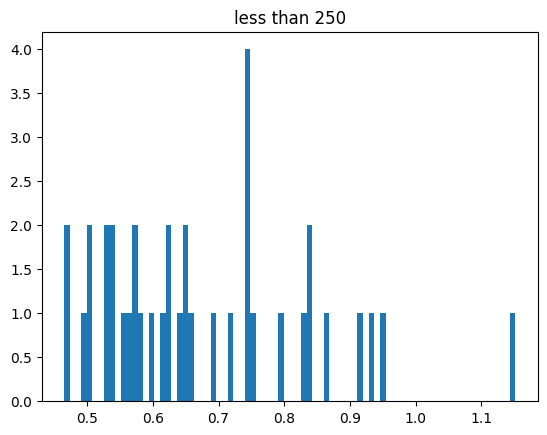

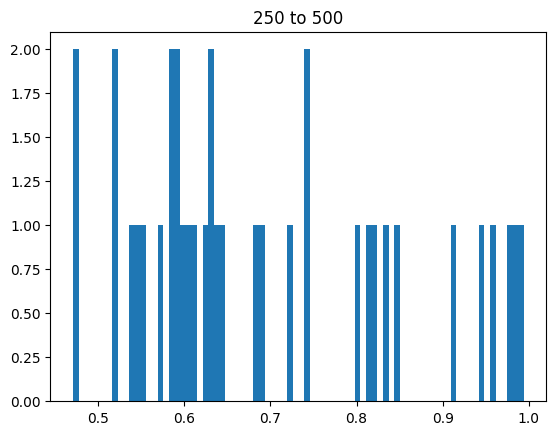

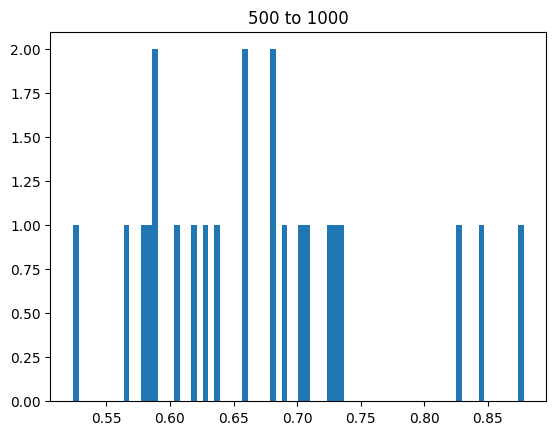

Without assistant :  1.2961069345474243  lookup val:  320  With assistant:  1.4817153066396713  lookup val:  160 <- greater


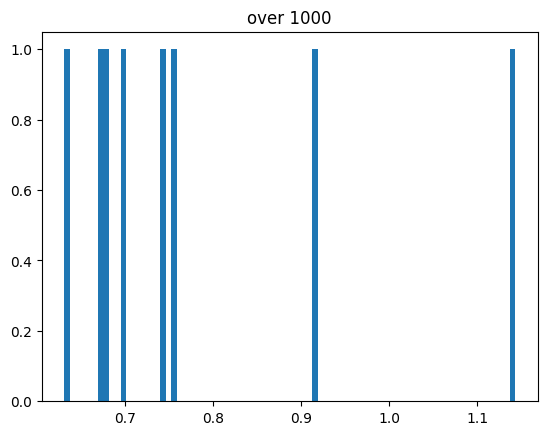

In [202]:
# Find the optimal for each
import numpy as np
import matplotlib.pyplot as plt

z = np.array(token_count)  
r = np.array(list(range(len(z))))
subsets = [r[z < 250], r[(z >= 250) & (z < 500)], r[(z >= 500) & (z < 1000)], r[z >= 1000]]
ssnames  = ["less than 250", "250 to 500", "500 to 1000", "over 1000"]
for ssname, subset in zip(ssnames, subsets):

    sratio = []

    for idx in subset:
        # print(idx)
        best_without_assistant = 1000000
        best_with_assistant = 10000000
    
        best_lookup_without_assistant = 0
        best_lookup_with_assistant = 0

        for lt in lookup_tokens:
            if time_taken[lt]["without_assistant"][idx] < best_without_assistant:
                best_without_assistant = time_taken[lt]["without_assistant"][idx]
                best_lookup_without_assistant = lt
            if time_taken[lt]["with_assistant"][idx] < best_without_assistant:
                best_with_assistant = time_taken[lt]["with_assistant"][idx]
                best_lookup_with_assistant = lt

    
        sratio.append(best_with_assistant/best_without_assistant)
        if sratio[-1] > 1:
            print("Without assistant : ", best_without_assistant, " lookup val: ",  best_lookup_without_assistant, " With assistant: ", best_with_assistant," lookup val: ", best_lookup_with_assistant, "<- greater" if best_with_assistant/best_without_assistant > 1 else "")
    plt.title(ssname)
    plt.hist(sratio, bins=80)
    plt.show()

In [ ]:
# sum(time_taken['with_assistant'])

In [ ]:
# sum(time_taken['without_assistant'])

In [ ]:
ratios = []
assisted_sum = 0
non_assisted_sum = 0
for idx, (i, j) in enumerate(zip(time_taken['with_assistant'], time_taken['without_assistant'])):
    ratios.append(i / j)
    if i / j > 1:
        print(outputs['with_assistant'][idx][0])
        if not(outputs['with_assistant'][idx][0] == outputs['without_assistant'][idx][0]):
            print("ERROR - with assistant and without assistant have different results. Without assistant:\n")
            print(outputs["without_assistant"][idx][0])
        print("============")
    else:
        assisted_sum += i
        non_assisted_sum += j
print(ratios)

In [ ]:
import difflib

count = 0
for wa, woa in zip(outputs['with_assistant'], outputs['without_assistant']):
    if not(wa[0] == woa[0]):
        count += 1
        print("Discrepancy: ")
        print("\n".join(difflib.unified_diff(woa[0].splitlines(), wa[0].splitlines())))

print(count)

In [ ]:
print(assisted_sum, non_assisted_sum, assisted_sum/non_assisted_sum)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ratios, bins=80)
plt.show()

In [ ]:
show_token_split_graphs(time_taken, token_count)

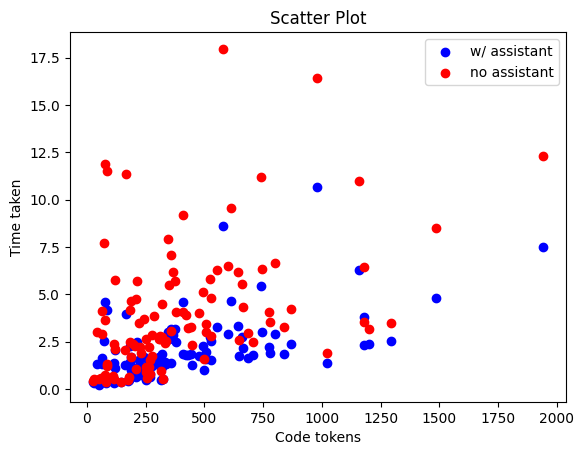

In [203]:
# Create scatter plots
plt.scatter(token_count, time_taken[80]["with_assistant"], color='blue', label='w/ assistant')
plt.scatter(token_count, time_taken[80]["without_assistant"], color='red', label='no assistant')

# Add title and labels
plt.title('Scatter Plot')
plt.xlabel('Code tokens')
plt.ylabel('Time taken')

# Add legend
plt.legend()
plt.show()